## Import packages

In [1]:
%matplotlib inline
import sys, os, re, csv, math, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, MaxPool1D, Flatten, Conv1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

/home/dislab/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define constants

In [2]:
EMBEDDING_FILE='./data/glove.6B.50d.txt'
TRAIN_DATA_FILE='./data/train.csv'
TEST_DATA_FILE='./data/test.csv'
MODEL_WEIGHTS_FILE = './toxic_model.h5'

In [3]:
embed_size = 50 # 단어를 몇 차원으로 임베딩할 것인가(how many dimensions use to embed word?) 
max_features = 20000 # 몇개의 단어를 주요한 특징으로 볼 것인가(How many words will be the main feature?) 
maxlen = 100 # 한 comment에서 가져올 수 있는 단어의 최대 갯수(The maximum number of words a comment can get?)

## Load Toxic data

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

In [5]:
list_sentences_train = train["comment_text"].fillna("_na_").values # comment_text만 가져와서 fillna를 통해 nan를 거른다.
                                                                   # Just import comment_text and filter nan through fillna.
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] # 사용할 컬럼들(to use columns)
y = train[list_classes].values # labels of comment_text
list_sentences_test = test["comment_text"].fillna("_na_").values # Do the same things for test_data

## Tokenize comment_text

In [6]:
tokenizer = Tokenizer(num_words=max_features) # max_features 만큼의 단어를 Tokenize하기 위한 틀 생성.
                                              # Create a frame to Tokenize words as many as max_features.
tokenizer.fit_on_texts(list(list_sentences_train)) # just fit
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train) # Tokenize(Transform word into number)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test) # Tokenize(Transform word into number)

In [7]:
list_tokenized_train # 각 문장(comment)의 단어들을 1(가장 많이 사용된 단어) ~ 20000(2만번째로 많이 사용된 단어) 으로 정수화함

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15188,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985],
 [52,
  2635,
  13,
  555,
  3809,
  73,
  4556,
  2706,
  21,
  94,
  38,
  803,
  2679,
  992,
  589,
  8377,
  182],
 [412,
  437,
  73,
  134,
  14,
  249,
  2,
  71,
  314,
  78,
  50,
  9,
  13,
  626,
  8,
  2284,
  492,
  502,
  102,
  4,
  611,
  2,
  35,
  325,
  126,
  363,
  3,
  29,
  38,
  27,
  52,
  208,
  2,
  434,
  57,
  36,
  1,
  2394,
  93,
  1,
  737,
  468],
 [57,
  7,
  228,
  97,
  54,
  328,
  1436,
  15,
  2133,
  7,
  6024,
  22,
  1,
  123,
  2502,
  56,
  16,
  513,
  15,
  25,
  5,
  4236,
  3,
  1327,
  3,
  9762,
  7,
  67,
  1,
  277,
  85,
  122,
  13502,
  37,
  9,
  51,
  19,
  42,
  10,
  1,
  1460,
  138,
  1257,
  2153,
  426,
 

In [8]:
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # 모든 단어는 각자 다른 길이를 갖고 있으므로 작은 길이의 문장에 
                                                         # padding을 해줌으로서 모든 문장의 길이를 maxlen로 맞춰줌
                                                         # All comment_texts are different in length, 
                                                         # so 0 is filled as much as maxlen in small sentences
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # do the same thing

In [9]:
X_t # 모든 문장의 길이를 maxlen으로 통일

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13674,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]], dtype=int32)

## Get GloVe vectors

In [10]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE)) # glove의 (단어, 벡터)를 가져옴
                                                                                     # Get (word, vector) of glove
embeddings_index

{'biennials': array([ 7.5302e-01,  8.0138e-01, -7.3877e-01, -4.9816e-01, -1.0483e+00,
        -5.8618e-01, -2.9853e-01, -1.4230e+00, -2.0396e-01,  1.5498e+00,
        -1.2425e-02,  5.0240e-01, -3.6418e-01, -4.3027e-01,  7.2810e-01,
        -5.6351e-01, -2.2224e-01,  7.0219e-01,  1.0883e-01, -5.7119e-01,
        -1.4105e-01, -5.4571e-01, -3.6199e-02, -2.0668e-01, -7.7737e-01,
         1.1948e+00,  6.1053e-02, -1.7883e-01, -5.0589e-01, -5.2099e-01,
        -1.1048e+00,  7.1149e-01,  4.3716e-01, -8.7338e-01,  5.5765e-02,
         8.4726e-02, -2.5316e-01,  1.1206e+00, -3.6558e-01,  6.8050e-02,
        -7.8459e-04, -1.0247e+00,  7.2503e-01,  4.6722e-01,  9.3257e-01,
         9.6082e-01,  1.1678e-01, -3.6218e-01, -1.4979e+00, -6.2008e-02],
       dtype=float32),
 'verplank': array([-3.2867e-01, -3.0691e-01, -3.2183e-02,  5.0435e-01, -4.6476e-02,
         6.9431e-01, -7.2077e-01,  5.8368e-01,  2.4879e-01, -8.2695e-01,
        -2.1425e-01, -2.6051e-01, -1.2449e+00,  5.1873e-01, -2.3939e-01,
  

In [11]:
all_embs = np.stack(embeddings_index.values()) # glove의 dict(embeddings_index)에서 벡터만 list 로 변환
                                               # Convert vectors of glove's dict(embeddings_index) into list
emb_mean,emb_std = all_embs.mean(), all_embs.std() # glove 벡터들의 평균과 표준편차를 구함
                                                   # Obtain the mean and standard deviation of glove vectors
emb_mean,emb_std

(0.020940464, 0.6441042)

## make embedding maxtirx based GloVe

In [12]:
word_index = tokenizer.word_index # tokenizer에 의해 얻어진 모든 단어들의 배열
                                  # an array of all the words obtained by the tokenizer
nb_words = min(max_features, len(word_index)) # glove의 영어단어는 너무 많으므로 max_features에 맞출지 word_index에 맞출지 정함
                                              # Because glove has too many English words, 
                                              # it determines whether the number of words matches max_features or word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) # (nb_words X embed_size) 크기의 벡터 필드를 설정
                                                                               # Set a vector field of size (nb_words X embed_size)

In [13]:
for word, i in word_index.items():
    if i >= max_features: 
        continue # 2만개 이상은 무시(Ignore more than max_feature.)
    embedding_vector = embeddings_index.get(word) # comment에서 사용된 단어의 벡터값을 glove에서 가져옴
                                                  # The vector value of the word used in comment is taken from glove
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector # embedding_matrix에 사용된 단어의 벡터값을 덮어 씌움
                                               # Override embedding_matrix with the vector value defined in glove.

## Define Model

In [14]:
inp = Input(shape=(maxlen,)) # X_t가 (maxlen, -1)인지 재확인 및 reshape
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # inp를 (max_features X embed_size)의 행렬에 weights의 가중치로 embedding

x = Conv1D(64, kernel_size=3, padding='same', name='conv1')(x) # CNN
x = BatchNormalization()(x) # batch normalization
x = ELU()(x) # ELU
x = MaxPool1D()(x) # maxpooling

x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x) # RNN중 하나인 LSTM사용 and maxpool
x = GlobalMaxPool1D()(x) # maxpolling

x = Dense(50, activation="relu")(x) # Fully connection layer
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x) # 결론


model = Model(inputs=inp, outputs=x) # 모델의 input, output설정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer는 adam loss는 binary_crossentropy로 구함

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

callbacks = [learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                      # approach to get optimal value by gradually decreasing learning_rate
             #EarlyStopping('val_loss', patience=2), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                     # If val_loss deviates from the optimal value, 
                                                     # learning stops even if epoch remains.
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.
                                                                       # Always store the optimal weights that have been shown so far 
                                                                       # while learning the model

history = model.fit(X_t, y, batch_size=32, epochs=5, validation_split=0.1, callbacks=callbacks); # 학습 시작

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 299s 2ms/step - loss: 0.0606 - acc: 0.9789 - val_loss: 0.0542 - val_acc: 0.9802
Epoch 2/5
143613/143613 [==============================] - 298s 2ms/step - loss: 0.0463 - acc: 0.9825 - val_loss: 0.0487 - val_acc: 0.9817
Epoch 3/5
143613/143613 [==============================] - 297s 2ms/step - loss: 0.0418 - acc: 0.9839 - val_loss: 0.0471 - val_acc: 0.9829
Epoch 4/5
143613/143613 [==============================] - 297s 2ms/step - loss: 0.0381 - acc: 0.9850 - val_loss: 0.0479 - val_acc: 0.9830
Epoch 5/5
143613/143613 [==============================] - 299s 2ms/step - loss: 0.0349 - acc: 0.9860 - val_loss: 0.0507 - val_acc: 0.9824


## Predict result

In [16]:
y_test = model.predict([X_te], batch_size=1024, verbose=1) # model에 test data를 넣고 예측
sample_submission = pd.read_csv('./data/sample_submission.csv') # 예측값을 저장할 csv파일
sample_submission[list_classes] = y_test # csv에 저장할 값을 설정
sample_submission.to_csv('./data/submission.csv', index=False) # csv파일에 저장

153164/153164 [==============================] - 35s 227us/step


## Make graph that compare loss and val_loss

/home/dislab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


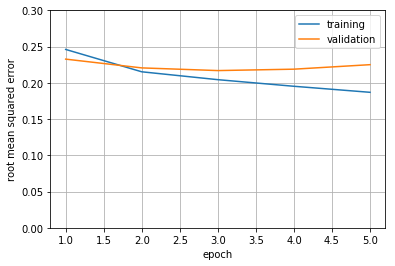

In [17]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.ix[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,0.3]);